# Transfer Learning with PyTorch using Azure Machine Learning

In [1]:
import os, random
import azureml
import shutil
import urllib.request
from pathlib import Path

from azureml.core.model import Model, InferenceConfig
from azureml.core import Workspace, Datastore, Experiment, Run
from azureml.core.compute import ComputeTarget, AmlCompute, AksCompute, ComputeTarget
from azureml.train.dnn import PyTorch
from azureml.widgets import RunDetails

from azureml.core.webservice import Webservice, AksWebservice, AciWebservice
from azureml.core.environment import Environment

from azureml.core.dataset import Dataset
from azureml.core.resource_configuration import ResourceConfiguration
from azureml.core.conda_dependencies import CondaDependencies 

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.3.0


## 1 - Connect to the AML Workspace Environment

In [2]:
azure_ml_workspace_name              = "Cybertron"
azure_ml_workspace_resource_group    = "Cybertron-RG"
azure_ml_workspace_subscription_id   = "431dbae5-40ca-438a-8daf-77d7d5580b41"
azure_ml_compute_target_name         = "OptimusPrime"

ExperimentName                       = 'Simpsons-PyTorch'

In [3]:
# Connect to workspace
#ws = Workspace.get(name=azure_ml_workspace_name, subscription_id=azure_ml_workspace_subscription_id, resource_group=azure_ml_workspace_resource_group)
#ws.write_config()
ws = Workspace.from_config()

# Connect to compute for training
compute_target = ComputeTarget(workspace=ws, name=azure_ml_compute_target_name)

# Connect to the datastore for the training images
ds = Datastore.get_default(ws)

# Connect to the experiment
exp = Experiment(workspace=ws, name=ExperimentName)

## 2 - Data

### 2.1 Download and extract the data

In [7]:
data_url = "https://github.com/hnky/dataset-lego-figures/raw/master/_download/train-and-validate.zip"
data_path = "./data"
download_path = os.path.join(data_path,"train-and-validate.zip")

In [8]:
import urllib3 
if not os.path.exists(data_path):
    os.mkdir(data_path,);
urllib.request.urlretrieve(data_url, filename=download_path)

('./data\\train-and-validate.zip', <http.client.HTTPMessage at 0x24bc4075908>)

In [9]:
import zipfile
zip_ref = zipfile.ZipFile(download_path, 'r')
zip_ref.extractall(data_path)
zip_ref.close()
print("Data extracted in: {}".format(data_path))

os.remove(download_path)
print("Downloaded file removed: {}".format(download_path))

Data extracted in: ./data
Downloaded file removed: ./data\train-and-validate.zip


### 2.2 Upload the data to AML datastore

In [10]:
# Upload all the data to the datastore
ds.upload(src_dir=data_path, target_path='simpsonslego-v2', overwrite=True, show_progress=True)

Uploading an estimated of 537 files
Uploading ./data\test\Flanders.jpg
Uploading ./data\test\Homer.jpg
Uploading ./data\train\Bart-Simpson\IMG_1652.JPG
Uploading ./data\train\Bart-Simpson\IMG_1653.JPG
Uploading ./data\train\Bart-Simpson\IMG_1654.JPG
Uploading ./data\train\Bart-Simpson\IMG_1656.JPG
Uploading ./data\train\Bart-Simpson\IMG_1657.JPG
Uploading ./data\train\Bart-Simpson\IMG_1658.JPG
Uploading ./data\train\Bart-Simpson\IMG_1659.JPG
Uploading ./data\train\Bart-Simpson\IMG_1660.JPG
Uploading ./data\train\Bart-Simpson\IMG_1661.JPG
Uploading ./data\train\Bart-Simpson\IMG_1662.JPG
Uploading ./data\train\Bart-Simpson\IMG_1663.JPG
Uploading ./data\train\Bart-Simpson\IMG_1664.JPG
Uploading ./data\train\Bart-Simpson\IMG_1666.JPG
Uploading ./data\train\Bart-Simpson\IMG_1667.JPG
Uploading ./data\train\Bart-Simpson\IMG_1668.JPG
Uploading ./data\train\Bart-Simpson\IMG_1670.JPG
Uploading ./data\train\Bart-Simpson\IMG_1672.JPG
Uploading ./data\train\Bart-Simpson\IMG_1673.JPG
Uploading ./dat

Uploading ./data\train\Dr-Hibbert\IMG_1431.JPG
Uploaded ./data\train\Chief-Wiggum\IMG_1741.JPG, 61 files out of an estimated total of 537
Uploading ./data\train\Dr-Hibbert\IMG_1433.JPG
Uploaded ./data\train\Chief-Wiggum\IMG_1746.JPG, 62 files out of an estimated total of 537
Uploaded ./data\train\Chief-Wiggum\IMG_1745.JPG, 63 files out of an estimated total of 537
Uploading ./data\train\Dr-Hibbert\IMG_1434.JPG
Uploading ./data\train\Dr-Hibbert\IMG_1436.JPG
Uploaded ./data\train\Bart-Simpson\IMG_1664.JPG, 64 files out of an estimated total of 537
Uploading ./data\train\Dr-Hibbert\IMG_1437.JPG
Uploaded ./data\train\Chief-Wiggum\IMG_1735.JPG, 65 files out of an estimated total of 537
Uploading ./data\train\Dr-Hibbert\IMG_1438.JPG
Uploaded ./data\train\Chief-Wiggum\IMG_1762.JPG, 66 files out of an estimated total of 537
Uploaded ./data\train\Chief-Wiggum\IMG_1761.JPG, 67 files out of an estimated total of 537
Uploaded ./data\train\Bart-Simpson\IMG_1660.JPG, 68 files out of an estimated tot

Uploaded ./data\train\Homer-Simpsons\IMG_0376.JPG, 122 files out of an estimated total of 537
Uploaded ./data\train\Homer-Simpsons\IMG_0375.JPG, 123 files out of an estimated total of 537
Uploading ./data\train\Homer-Simpsons\IMG_0405.JPG
Uploading ./data\train\Homer-Simpsons\IMG_0406.JPG
Uploaded ./data\train\Homer-Simpsons\IMG_0358.JPG, 124 files out of an estimated total of 537
Uploading ./data\train\Homer-Simpsons\IMG_0407.JPG
Uploaded ./data\train\Chief-Wiggum\IMG_1767.JPG, 125 files out of an estimated total of 537
Uploaded ./data\train\Homer-Simpsons\IMG_0381.JPG, 126 files out of an estimated total of 537
Uploading ./data\train\Homer-Simpsons\IMG_0408.JPG
Uploading ./data\train\Homer-Simpsons\IMG_0409.JPG
Uploaded ./data\train\Chief-Wiggum\IMG_1766.JPG, 127 files out of an estimated total of 537
Uploading ./data\train\Homer-Simpsons\IMG_0411.JPG
Uploaded ./data\train\Homer-Simpsons\IMG_0374.JPG, 128 files out of an estimated total of 537
Uploading ./data\train\Homer-Simpsons\IM

Uploaded ./data\train\Krusty-the-Clown\IMG_1503.JPG, 181 files out of an estimated total of 537
Uploading ./data\train\Krusty-the-Clown\IMG_1531.JPG
Uploaded ./data\train\Dr-Hibbert\IMG_1437.JPG, 182 files out of an estimated total of 537
Uploading ./data\train\Krusty-the-Clown\IMG_1532.JPG
Uploaded ./data\train\Chief-Wiggum\IMG_1722.JPG, 183 files out of an estimated total of 537
Uploading ./data\train\Krusty-the-Clown\IMG_1533.JPG
Uploaded ./data\train\Krusty-the-Clown\IMG_1517.JPG, 184 files out of an estimated total of 537
Uploading ./data\train\Krusty-the-Clown\IMG_1534.JPG
Uploaded ./data\train\Krusty-the-Clown\IMG_1505.JPG, 185 files out of an estimated total of 537
Uploading ./data\train\Krusty-the-Clown\IMG_1536.JPG
Uploaded ./data\train\Krusty-the-Clown\IMG_1513.JPG, 186 files out of an estimated total of 537
Uploading ./data\train\Krusty-the-Clown\IMG_1537.JPG
Uploaded ./data\train\Krusty-the-Clown\IMG_1509.JPG, 187 files out of an estimated total of 537
Uploading ./data\tra

Uploading ./data\train\Marge-Simpsons\IMG_0350.JPG
Uploading ./data\train\Marge-Simpsons\IMG_0351.JPG
Uploaded ./data\train\Lisa-Simpson\IMG_1866.JPG, 248 files out of an estimated total of 537
Uploading ./data\train\Marge-Simpsons\IMG_0369.JPG
Uploaded ./data\train\Lisa-Simpson\IMG_1872.JPG, 249 files out of an estimated total of 537
Uploading ./data\train\Marge-Simpsons\IMG_0370.JPG
Uploaded ./data\train\Lisa-Simpson\IMG_1874.JPG, 250 files out of an estimated total of 537
Uploading ./data\train\Marge-Simpsons\IMG_0371.JPG
Uploaded ./data\train\Lisa-Simpson\IMG_1873.JPG, 251 files out of an estimated total of 537
Uploading ./data\train\Marge-Simpsons\IMG_0372.JPG
Uploaded ./data\train\Homer-Simpsons\IMG_0420.JPG, 252 files out of an estimated total of 537
Uploaded ./data\train\Lisa-Simpson\IMG_1879.JPG, 253 files out of an estimated total of 537
Uploading ./data\train\Marge-Simpsons\IMG_0373.JPG
Uploading ./data\train\Marge-Simpsons\IMG_0384.JPG
Uploaded ./data\train\Marge-Simpsons\I

Uploading ./data\train\Milhouse-van-Houten\IMG_1801.JPG
Uploaded ./data\train\Milhouse-van-Houten\IMG_1778.JPG, 305 files out of an estimated total of 537
Uploading ./data\train\Milhouse-van-Houten\IMG_1802.JPG
Uploaded ./data\train\Milhouse-van-Houten\IMG_1782.JPG, 306 files out of an estimated total of 537
Uploading ./data\train\Milhouse-van-Houten\IMG_1803.JPG
Uploaded ./data\train\Milhouse-van-Houten\IMG_1775.JPG, 307 files out of an estimated total of 537
Uploading ./data\train\Milhouse-van-Houten\IMG_1805.JPG
Uploaded ./data\train\Marge-Simpsons\IMG_0443.JPG, 308 files out of an estimated total of 537
Uploading ./data\train\Milhouse-van-Houten\IMG_1806.JPG
Uploaded ./data\train\Marge-Simpsons\IMG_0338.JPG, 309 files out of an estimated total of 537
Uploading ./data\train\Milhouse-van-Houten\IMG_1808.JPG
Uploaded ./data\train\Milhouse-van-Houten\IMG_1785.JPG, 310 files out of an estimated total of 537
Uploading ./data\train\Milhouse-van-Houten\IMG_1809.JPG
Uploaded ./data\train\Mi

Uploading ./data\train\Ned-Flanders\IMG_1609.JPG
Uploaded ./data\train\Mr-Burns\IMG_1591.JPG, 373 files out of an estimated total of 537
Uploading ./data\train\Ned-Flanders\IMG_1610.JPG
Uploaded ./data\train\Mr-Burns\IMG_1598.JPG, 374 files out of an estimated total of 537
Uploading ./data\train\Ned-Flanders\IMG_1611.JPG
Uploaded ./data\train\Mr-Burns\IMG_1584.JPG, 375 files out of an estimated total of 537
Uploading ./data\train\Ned-Flanders\IMG_1613.JPG
Uploaded ./data\train\Mr-Burns\IMG_1585.JPG, 376 files out of an estimated total of 537
Uploading ./data\train\Ned-Flanders\IMG_1614.JPG
Uploaded ./data\train\Mr-Burns\IMG_1594.JPG, 377 files out of an estimated total of 537
Uploaded ./data\train\Mr-Burns\IMG_1595.JPG, 378 files out of an estimated total of 537
Uploading ./data\train\Ned-Flanders\IMG_1615.JPG
Uploading ./data\train\Ned-Flanders\IMG_1616.JPG
Uploaded ./data\train\Mr-Burns\IMG_1589.JPG, 379 files out of an estimated total of 537
Uploading ./data\train\Ned-Flanders\IMG_1

Uploaded ./data\val\Dr-Hibbert\IMG_1466.JPG, 446 files out of an estimated total of 537
Uploading ./data\val\Krusty-the-Clown\IMG_1485.JPG
Uploaded ./data\val\Dr-Hibbert\IMG_1472.JPG, 447 files out of an estimated total of 537
Uploading ./data\val\Krusty-the-Clown\IMG_1490.JPG
Uploaded ./data\val\Dr-Hibbert\IMG_1435.JPG, 448 files out of an estimated total of 537
Uploading ./data\val\Krusty-the-Clown\IMG_1493.JPG
Uploaded ./data\val\Dr-Hibbert\IMG_1446.JPG, 449 files out of an estimated total of 537
Uploading ./data\val\Krusty-the-Clown\IMG_1500.JPG
Uploaded ./data\val\Homer-Simpsons\IMG_0353.JPG, 450 files out of an estimated total of 537
Uploading ./data\val\Krusty-the-Clown\IMG_1507.JPG
Uploaded ./data\val\Chief-Wiggum\IMG_1712.JPG, 451 files out of an estimated total of 537
Uploading ./data\val\Krusty-the-Clown\IMG_1514.JPG
Uploaded ./data\val\Dr-Hibbert\IMG_1432.JPG, 452 files out of an estimated total of 537
Uploading ./data\val\Krusty-the-Clown\IMG_1520.JPG
Uploaded ./data\val\D

Uploaded ./data\val\Milhouse-van-Houten\IMG_1791.JPG, 522 files out of an estimated total of 537
Uploaded ./data\val\Krusty-the-Clown\IMG_1485.JPG, 523 files out of an estimated total of 537
Uploaded ./data\val\Milhouse-van-Houten\IMG_1770.JPG, 524 files out of an estimated total of 537
Uploaded ./data\val\Ned-Flanders\IMG_1607.JPG, 525 files out of an estimated total of 537
Uploaded ./data\val\Ned-Flanders\IMG_1637.JPG, 526 files out of an estimated total of 537
Uploaded ./data\val\Ned-Flanders\IMG_1625.JPG, 527 files out of an estimated total of 537
Uploaded ./data\val\Ned-Flanders\IMG_1617.JPG, 528 files out of an estimated total of 537
Uploaded ./data\val\Ned-Flanders\IMG_1621.JPG, 529 files out of an estimated total of 537
Uploaded ./data\val\Ned-Flanders\IMG_1612.JPG, 530 files out of an estimated total of 537
Uploaded ./data\val\Dr-Hibbert\IMG_1453.JPG, 531 files out of an estimated total of 537
Uploaded ./data\val\Lisa-Simpson\IMG_1851.JPG, 532 files out of an estimated total o

$AZUREML_DATAREFERENCE_499e433374d84848b103457edf0dd592

### 2.3 Create a Dataset from the images

In [4]:
# create a FileDataset pointing to files in 'simpsons' folder and its subfolders recursively
datastore_paths = [(ds, 'simpsonslego-v2/**')]
simpsons_ds = Dataset.File.from_files(path=datastore_paths)

In [5]:
# Register the dataset in AMLS
simpsons_ds.register(workspace=ws,
             name='LegoSimpsons',
             description='Simpsons dataset with Lego Figures',
             create_new_version = True)

{
  "source": [
    "('workspaceblobstore', 'simpsonslego-v2/**')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "id": "051d3eb4-5f1d-4de8-810e-7e0b5b839ddc",
    "name": "LegoSimpsons",
    "version": 1,
    "description": "Simpsons dataset with Lego Figures",
    "workspace": "Workspace.create(name='Cybertron', subscription_id='431dbae5-40ca-438a-8daf-77d7d5580b41', resource_group='Cybertron-RG')"
  }
}

In [41]:
# Or connect to previous version of the data
simpsons_ds = Dataset.get_by_name(ws, name='LegoSimpsons')

## Preview the dataset

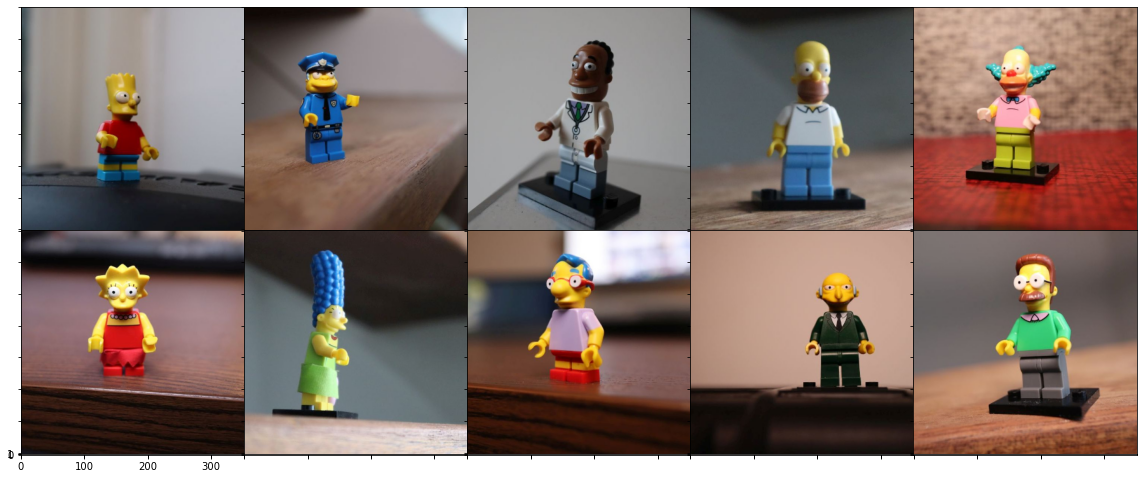

In [68]:
path = r"data/train"
random_filenames = []
for tag in os.listdir(path):
    random_filenames.append(path+"/"+tag+"/"+random.choice([
        x for x in os.listdir(os.path.join(path,tag))
        if os.path.isfile(os.path.join(path,tag, x))
    ]))

grid = AxesGrid(plt.figure(1, (20,20)), 111, nrows_ncols=(4, 5), axes_pad=0, label_mode="1")

i = 0
for img_name in random_filenames[0:10]:
    
    # Download image
    image = cv2.imread(img_name)
    image = cv2.resize(image, (352, 352))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Show image in grid
    grid[i].imshow(image)
    i = i+1

## 3 - Train the model

### 3.1 Create a training script

In [6]:
%%writefile 'trainingscripts/train.py'

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

### Add References
import argparse
from azureml.core import Run

### Add run context for AML
run = Run.get_context()

### Parse incoming parameters
parser = argparse.ArgumentParser()
parser.add_argument("--data-folder", type=str, dest="data_folder", help="data folder mounting point", default="")

args = parser.parse_args()
data_path = os.path.join(args.data_folder,'simpsonslego-v2')
data_path = args.data_folder


### Prepare the dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            print(phase,running_loss,dataset_sizes[phase])
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Log the los / acc to AMLS
            run.log("{} Loss".format(phase), np.float(epoch_loss))
            run.log("{} Acc".format(phase), np.float(epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

# Save the model
torch.save(model_ft, './outputs/model.pth')

# Save the labels
with open('./outputs/labels.txt', 'w') as f:
    f.writelines(["%s\n" % item  for item in class_names])

Overwriting trainingscripts/train.py


### 3.2 Create and run a PyTorch Estimator

In [7]:
# Create the PyTorch estimator
script_params = {
    '--data-folder': simpsons_ds.as_named_input('simpsonsdataset').as_mount()
}

# The folder that contains your training script.
# This contents folder is being versioned in the experiment.
project_folder = "./trainingscripts"

estimator = PyTorch(source_directory=project_folder, 
                    script_params=script_params,
                    compute_target=compute_target,
                    entry_script='train.py',
                    use_gpu=True,
                    pip_packages=['azureml-dataprep[fuse,pandas]','pillow==5.4.1'],
                    framework_version='1.3')

In [8]:
# Run the PyTorch estimator
run = exp.submit(estimator)

In [9]:
# Show the PyTorch estimator
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [10]:
# Handy functions
print(run.status)
#run.cancel()

Starting


In [15]:
# Load a historic run
previousRunId = '<Insert id from a previous run>'
run = [r for r in exp.get_runs() if r.id == previousRunId][0]
print(run)
RunDetails(run).show()

Run(Experiment: Simpsons-PyTorch-Heijmans,
Id: Simpsons-PyTorch-Heijmans_1585816105_4754fbd0,
Type: azureml.scriptrun,
Status: Completed)


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### 3.3 Register the model in Azure ML

In [11]:
model = run.register_model(model_name='Simpsons-PyTorch',
                           model_path='outputs',
                           model_framework='PyTorch',
                           model_framework_version='1.3',
                           description="Simpsons PyTorch Classifier (From Jupyter Notebook)",
                           resource_configuration=ResourceConfiguration(cpu=1, memory_in_gb=2))

print("Model '{}' version {} registered ".format(model.name,model.version))

Model 'Simpsons-PyTorch' version 2 registered 


### 3.4 Download & Test the model

In [12]:
model.download(exist_ok=True)

'outputs'

In [13]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import json
import urllib
from PIL import Image

model_path = os.path.join('outputs','model.pth')
labels_path = os.path.join('outputs','labels.txt')

# Load the model
loaded_model = torch.load(model_path, map_location=lambda storage, loc: storage)
loaded_model.eval()

# Load the labels
with open(labels_path, 'rt') as lf:
    global labels
    labels = [l.strip() for l in lf.readlines()]

# Load the image to predict
input_image = Image.open("data/test/Flanders.jpg")
input_image = Image.open("data/test/Homer.jpg")

# Pre process
preprocess = transforms.Compose([
    transforms.Resize(225),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

# Predict the image
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    loaded_model.to('cuda')

with torch.no_grad():
    output = loaded_model(input_batch)

index = output.data.cpu().numpy().argmax()
probability = torch.nn.functional.softmax(output[0], dim=0).data.cpu().numpy().max()

# Show result
result = {"label": labels[index], "probability": round(probability*100,2)}
print(result)

{'label': 'Homer-Simpsons', 'probability': 92.85}


## 4 Deploy the model

### 4.1 Create a scoring script

In [14]:
%%writefile 'score.py'
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import json
import urllib
from PIL import Image

from azureml.core.model import Model

def init():
    global model
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'outputs','model.pth')
    labels_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'outputs','labels.txt')
    
    print('Loading model...', end='')
    model = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.eval()
    
    print('Loading labels...', end='')
    with open(labels_path, 'rt') as lf:
        global labels
        labels = [l.strip() for l in lf.readlines()]
    print(len(labels), 'found. Success!')

    
def run(input_data):
    url = json.loads(input_data)['url']
    urllib.request.urlretrieve(url, filename="tmp.jpg")
    
    input_image = Image.open("tmp.jpg")

    preprocess = transforms.Compose([
        transforms.Resize(225),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    index = output.data.cpu().numpy().argmax()
    probability = torch.nn.functional.softmax(output[0], dim=0).data.cpu().numpy().max()

    result = {"label": labels[index], "probability": round(probability*100,2)}
    os.remove("tmp.jpg")
    return result

Overwriting score.py


### 4.2 Create an environment file

In [15]:
myenv = CondaDependencies.create(pip_packages=['azureml-defaults ', 'torch', 'torchvision','pillow==5.4.1'])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())
    
myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")

### 4.3 Create an Inference config

In [16]:
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

### 4.4 Deploy to ACI

In [17]:
model = Model(ws, name='Simpsons-PyTorch')
print("Loaded model version:",model.version)

Loaded model version: 2


In [18]:
# Create a deployment config
deploy_config = AciWebservice.deploy_configuration(
                    cpu_cores = model.resource_configuration.cpu, 
                    memory_gb = model.resource_configuration.memory_in_gb,
                    description='Simpson Lego Classifier')

In [19]:
# Deploy the model to an ACI
aci_service = Model.deploy(ws, 
                name="simpsons-pt-aci", 
                models = [model], 
                inference_config = inference_config, 
                deployment_config = deploy_config, 
                overwrite = True)

aci_service.wait_for_deployment(show_output=True)

Running........
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [ ]:
# Connect to previous deployment
aci_service = AciWebservice(ws, "simpsons-pt-aci")

In [20]:
print("Scoring endpoint:",aci_service.scoring_uri)

Scoring endpoint: http://f401ce93-9bc7-468c-8d0d-7566e6a1f0ec.westeurope.azurecontainer.io/score


### 4.4 Deploy to Azure Kuberneter Service

In [ ]:
aks_target = AksCompute(ws,"AI-AKS-DEMO")

deployment_config = AksWebservice.deploy_configuration(
    cpu_cores = 1, 
    memory_gb = 2)

aks_service = Model.deploy(workspace=ws, 
                       name="simpsons-pytorch-XXX", 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=deployment_config, 
                       deployment_target=aks_target)

aks_service.wait_for_deployment(show_output = True)

In [146]:
### Connect to a previous deployed service
aks_service = [r for r in AksWebservice.list(ws) if r.name == 'simpsons-pytorch-XXX'][0]

In [ ]:
print(aks_service.scoring_uri)
aks_service.get_keys()

### 4.4 Test the API

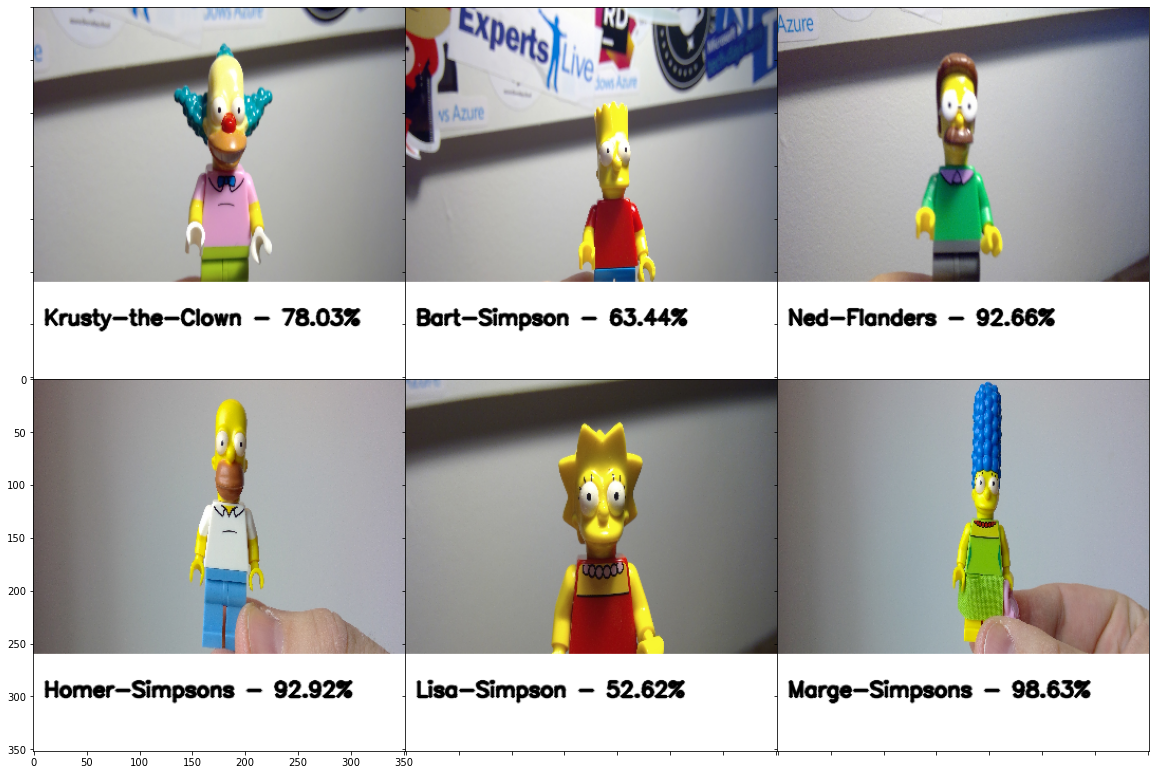

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from PIL import Image as ImagePil
import requests
from io import BytesIO
import cv2
import urllib
import cv2
import numpy as np
import json

F = plt.figure(1, (20,20))
grid = AxesGrid(F, 111, nrows_ncols=(2, 3), axes_pad=0, label_mode="1")


with open('test-images-urls.txt', 'rt') as lf:
    images = [l.strip() for l in lf.readlines()]

testimages = images


def url_to_image(url):
    with urllib.request.urlopen(url) as url:
        s = url.read()
    image = np.asarray(bytearray(s), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (352, 352))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


i = 0
for img_name in testimages[0:6]:
    
    # Predict Url
    result = aci_service.run(input_data=json.dumps({ "url": img_name}))

    # Download image
    img = url_to_image(img_name)
 
    # Draw result on image
    text = "{} - {}%".format(result['label'],result['probability'])
    cv2.rectangle(img, (0,260),(352,352),(255,255,255), -1)
    cv2.putText(img, text,(10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.65,(0,0,0),2,cv2.LINE_AA)

    # Show image in grid
    grid[i].imshow(img)
    i = i+1